## Analyse von Phyphox Daten

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series
import numpy as np
from scipy import signal 
import os
%matplotlib ipympl
plt.close()

In [18]:
# Einlesen der Messdaten
working_dir = "/Users/dirkm/Documents/Github/python_experiments"
os.chdir(working_dir)
new_dir = os.getcwd()
print("New current working directory:", new_dir)
#experiment_dir = "2024-07-14_12-54-33"
#experiment_dir = "2024-07-14_13-11-02"
#experiment_dir = "2024-07-14_13-02-27"
#experiment_dir = "2024-07-14_13-44-06"
#experiment_dir = "2024-07-14_12-56-08"
#experiment_dir = "2024-07-14_13-21-20"
###
experiment_dir = "2024-07-20_12-12-52"
#data_dir = working_dir + "/Beschleunigung ohne g " + experiment_dir
data_dir = working_dir + "/My Experiment " + experiment_dir
os.chdir(data_dir)
new_dir = os.getcwd()
print("New current working directory:", new_dir)
#testdata = pd.read_csv("Raw data.csv") 
testdata = pd.read_csv("Linear Acceleration.csv") 
testdata.head()
df = testdata.rename(columns={"Time (s)": "t", "Linear Acceleration x (m/s^2)" : "x", "Linear Acceleration y (m/s^2)" : "y", "Linear Acceleration z (m/s^2)" : "z" })

New current working directory: C:\Users\dirkm\Documents\Github\python_experiments
New current working directory: C:\Users\dirkm\Documents\Github\python_experiments\My Experiment 2024-07-20_12-12-52


In [19]:
# Einlesen von Daten aus der Simulation
data_dir = working_dir 
os.chdir(data_dir)
new_dir = os.getcwd()
testdata = pd.read_csv("pendulum_data.csv") 
print(testdata.head())
df = testdata.rename(columns={"time":"t", "theta_noisy":"tn", "theta":"tx", "theta_dot":"txd"})
print(df.head())

       time  theta_noisy     theta  theta_dot
0  0.000000     0.000000  0.000000   0.000000
1  0.100503    -0.089769  0.000997   0.019405
2  0.201005     0.089970  0.002819   0.016460
3  0.301508    -0.077778  0.003636   0.000402
4  0.402010    -0.077835  0.004873   0.024322
          t        tn        tx       txd
0  0.000000  0.000000  0.000000  0.000000
1  0.100503 -0.089769  0.000997  0.019405
2  0.201005  0.089970  0.002819  0.016460
3  0.301508 -0.077778  0.003636  0.000402
4  0.402010 -0.077835  0.004873  0.024322


<Axes: xlabel='t [s]', ylabel='theta_x_dot [rad]'>

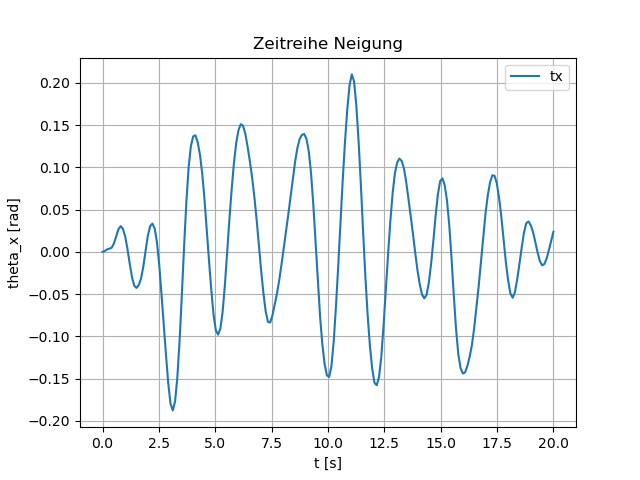

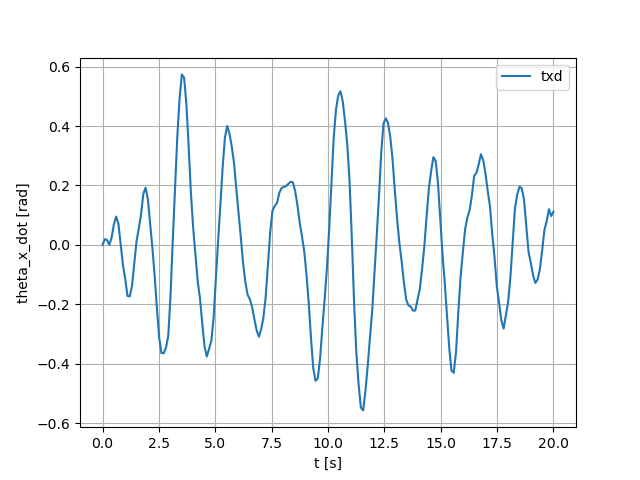

In [20]:
df.plot("t","tx", grid=True, xlabel = "t [s]", ylabel = "theta_x [rad]", title="Zeitreihe Neigung")
df.plot("t","txd", grid=True, xlabel = "t [s]", ylabel = "theta_x_dot [rad]")

In [21]:
# Abtastintervall
dt = df.t[1] - df.t[0]
fs = 1/dt
print(fs)

9.950000000000006


In [22]:
f, PXX = signal.periodogram(df.tx, fs)
#f, PYY = signal.periodogram(df.ty, fs)
#f, PZZ = signal.periodogram(df.tz, fs)

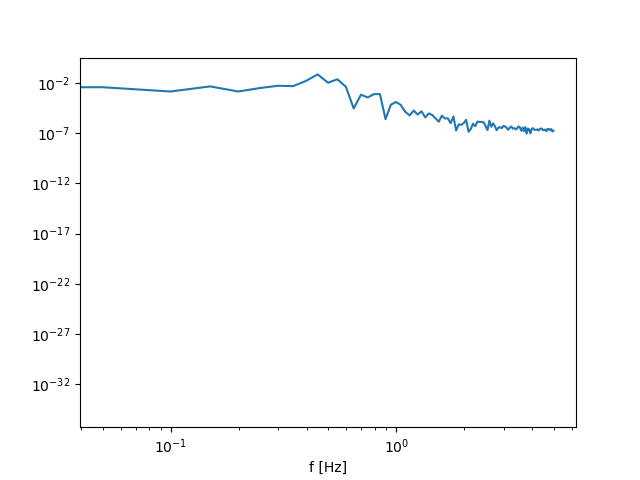

In [23]:
plt.figure()
plt.loglog(f, PXX)
#plt.loglog(f, PYY)
#plt.loglog(f, PZZ)
plt.xlabel("f [Hz]")
plt.show()

In [24]:
# Funktionen für die Kalman Filterung 

In [25]:
X = np.array([0.0]) # Zustand: Auslenkung 
A = np.array([[1.0]])
H = np.array([[1.0]]) # Messung der Auslenkung -> vor dem Einsetzen von Y aus dem Drehwinkel berechnen berechnen
R = np.array([[1.0]])*10
P = np.array([[1.0]])
Q = np.array([[0.1]])
U = 0 # Eingangsgröße Drehwinkelrate
B = np.array([dt])

In [26]:
def kf_predict(X, P, A, Q, B, U):
    X = np.dot(A, X) + np.dot(B, U)
    P = np.dot(A, np.dot(P, A.T)) + Q
    return(X,P)

In [27]:
def kf_update(X, P, Y, H, R):
    IM = np.dot(H, X)
    IS = R + np.dot(H, np.dot(P, H.T))
    K = np.dot(P, np.dot(H.T, np.linalg.inv(IS)))
    X = X + np.dot(K, (Y-IM))
    P = P - np.dot(K, np.dot(IS, K.T))
    LH = gauss_pdf(Y, IM, IS)
    return (X,P,K,IM,IS,LH)

In [28]:
def gauss_pdf(X, M, S):
    if np.shape(M)[0] == 1:
        DX = X - np.tile(M, np.shape(X)[1])
        E = 0.5 * np.sum(DX * (np.dot(np.linalg.inv(S), DX)), axis=0)
        E = E + 0.5 * np.shape(M)[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)
    elif np.shape(X)[0] == 1:
        DX = np.tile(X, M.shape()[1])- M
        E = 0.5 * np.sum(DX * (np.dot(np.linalg.inv(S), DX)), axis=0)
        E = E + 0.5 * np.shape(M)[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)
    else:
        DX = X-M
        E = 0.5 * np.dot(DX.T, np.dot(np.linalg.inv(S), DX))
        E = E + 0.5 * np.shape(M)[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)
    return (P[0],E[0])

In [29]:
thx = df.tn
thxd = df.txd
t = df.t

In [30]:
n = 0
thx_e = np.zeros_like(thx)
kalman_gain = np.zeros_like(thx)

In [31]:
while n < len(thx):
    U = np.array([[thxd[n]]])
    (X, P) = kf_predict(X, P, A, Q, B, U)
    Y = np.array([[thx[n]]])
    (X, P, K, IM, IS, LH) = kf_update(X, P, Y, H, R)
    thx_e[n] = np.ndarray.item(X, 0)
    kalman_gain[n] = np.ndarray.item(K, 0)
    n += 1 

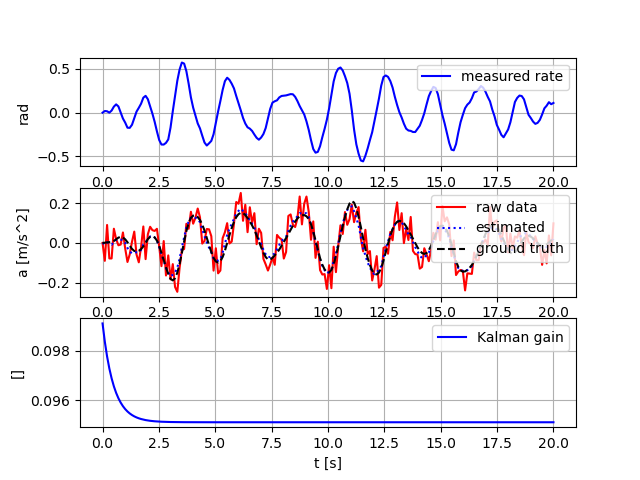

In [33]:
plt.figure()

plt.subplot(3,1,1)
plt.plot(t, thxd, 'b', label = "measured rate")
plt.xlabel("t [s]")
plt.ylabel("rad")
plt.grid()
plt.legend()

plt.subplot(3,1,2)
plt.plot(t, thx, 'r', label = "raw data")
plt.plot(t, thx_e, 'b:', label = "estimated")
plt.plot(t, df.tx, 'k--', label = 'ground truth')
plt.xlabel("t [s]")
plt.ylabel("a [m/s^2]")
plt.grid()
plt.legend()

plt.subplot(3,1,3)
plt.plot(t, kalman_gain, 'b', label = "Kalman gain")
plt.xlabel("t [s]")
plt.ylabel("[]")
plt.grid()
plt.legend()


plt.show()